# U-Net with Pretrained MobileNetV2 as Encoder

## What is U-Net
Paper: <a href="https://arxiv.org/abs/1505.04597"> https://arxiv.org/abs/1505.04597 </a>

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations.

<img src="images/u-net-architecture.png">

<br/>
UNet Architecture has 3 parts:
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3>
 <ul>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li>
    <li>At each downsampling step we double the number of feature channels.</li>
</ul>

<h3>Upsampling Path: </h3>
<ul>
    <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ul>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.
<br/> <br/> <br/>
<hr>

## What is MobileNetV2
Paper: <a href="https://arxiv.org/pdf/1801.04381.pdf"> https://arxiv.org/pdf/1801.04381.pdf </a>

MobileNetV2 is a architecture that is optimized for mobile devices. It improves the state of the art performance of mobile models on multiple tasks and benchmarks as well as across a spectrum of different model
sizes.

<img src="images/MobileNetV2 architecture.png" style="height:400px; ">

The MobileNetV2 is used for the encoder/downsampling path of the U-Net (the left half of the U)
<br/> <br/> <br/>
<hr>

## What are the Advantages of using a MobileNetV2 as Pretrained Encoder

<ul>
    <li> MobileNetV2 has less parameters, due to which it is easy to train. </li>
    <li> Using a pretrained encoder helps the model to converge much faster in comparison to the non-pretrained model. </li>
    <li> A pretrained encoder helps the model to achieve high performance as compared to non-pretrained model.</li>
</ul>
<br/>
<hr>

## Importing Libraries and Functions

In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

import pandas as pd
import skimage
from skimage import io
import numpy as np
import scipy#.interpolate.UnivariateSpline
from skimage.draw import polygon
from skimage.transform import resize

In [2]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.2.0


Seeding

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

In [11]:
IMAGE_SIZE = 500
EPOCHS = 100
BATCH = 2
LR = 1e-4

PATH = ""

## Dataset
You can download the dataset from <a href="https://polyp.grand-challenge.org/CVCClinicDB/">here</a> or from directly from the <a href="https://www.dropbox.com/s/p5qe9eotetjnbmq/CVC-ClinicDB.rar?dl=0">Dropbox</a>.

<br/>
Spliting the data into training, validation and testing with 80:10:10 ratio.

In [35]:
!dir ..

 Volume in drive C is Windows 
 Volume Serial Number is 1689-EC4D

 Directory of C:\Data\data_area_pred

29/03/2021  21:04    <DIR>          .
29/03/2021  21:04    <DIR>          ..
22/01/2021  18:09    <DIR>          autoencoder_extract
30/03/2021  16:48    <DIR>          files
16/01/2021  14:12    <DIR>          metric_calibration
31/03/2021  11:08    <DIR>          notebooks
12/01/2021  17:39    <DIR>          raw_masks_json
12/01/2021  17:44    <DIR>          run_log
22/01/2021  14:18    <DIR>          saved_tensors_day_35
29/03/2021  20:10    <DIR>          scripts
29/03/2021  21:04    <DIR>          temp
12/01/2021  23:17    <DIR>          Unet_pred
12/01/2021  17:40    <DIR>          Unet_train
               0 File(s)              0 bytes
              13 Dir(s)  362.154.848.256 bytes free


In [ ]:
PATH

In [32]:
glob(os.path.join(PATH, "images_pn/*"))

[]

In [24]:
def load_data(path, split=0.15):
    images = sorted(glob(os.path.join(path, "images_pn/*")))#
    masks = sorted(glob(os.path.join(path, "masks_pn/*")))#[:-246]
    images.sort(key=natural_keys)
    masks.sort(key=natural_keys)
    #images = images[:-246]
    #masks = masks[:-246]
    
    total_size = len(images)
    print(total_size)
    valid_size = int(split * total_size)
   # test_size = int(0.05 * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42, shuffle=False)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42, shuffle=False)

    #train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    #train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)#, (test_x, test_y)

Reading the images and masks

In [25]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))  
    # zero padding 
    color = [0,0,0]
    #x = cv2.copyMakeBorder(x.copy(),6,6,6,6,cv2.BORDER_CONSTANT,value=color)
    #clahe = cv2.createCLAHE(clipLimit=12.0, tileGridSize=(8,8))
    #temp = clahe.apply(x[:,:,0])
    # = np.stack((temp,)*3, axis=-1)
    #x[:,:,0] = temp
    #x[:,:,1] = temp
    #x[:,:,2] = temp
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    # zero padding 
    color = [0,0,0]
    #x = cv2.copyMakeBorder(x.copy(),6,6,6,6,cv2.BORDER_CONSTANT,value=color)
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x


Building the tf.data pipeline for training, validation and testing dataset.

In [26]:

import tensorflow_addons as tfa

In [27]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    
    return x, y

def tf_dataset(x, y, batch=8, aug=False):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    if aug:
        dataset = dataset.map(augment)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


def flip_image_vertically(image, mask):
    """Randomly flip an image and label vertically (left to right).
    """
    uniform_random = tf.random.uniform([], 0, 1.0)
    flip_cond = tf.less(uniform_random, .5)
    image = tf.cond(flip_cond, lambda: tf.image.flip_up_down(image), lambda: image)
    mask = tf.cond(flip_cond, lambda: tf.image.flip_up_down(mask), lambda: mask)

    return image, mask


def augment(image, mask):
    
    angle = tf.random.uniform([], -2.0, 2.0)
    image = tfa.image.rotate(image, angle, interpolation = 'NEAREST')
    mask = tfa.image.rotate(mask, angle, interpolation = 'NEAREST')
    
    delta = tf.random.uniform([], 0, 0.4)
   # image = tf.image.adjust_brightness(image, delta=delta)
   # mask = tf.image.adjust_brightness(mask, delta=delta)
    
    contrast_factor = tf.random.uniform([], 0, 2)
    #image = tf.image.adjust_contrast(image, contrast_factor)
    #mask = tf.image.adjust_contrast(mask, contrast_factor)
    
    return image, mask

In [28]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]



In [29]:


(train_x, train_y), (valid_x, valid_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
#print("Testing data: ", len(test_x))

0


ValueError: test_size=0 should be either positive and smaller than the number of samples 0 or a float in the (0, 1) range

In [12]:
# (test_x, test_y)

In [12]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

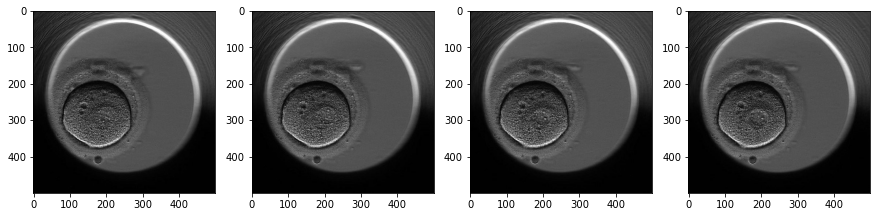

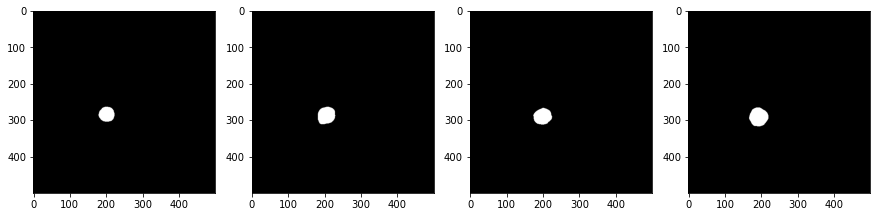

In [13]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

## Model

In [14]:
read_and_rgb(train_y[3]).shape

(500, 500, 3)

In [17]:
IMAGE_SIZE = 256
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=1.4)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", 
                             "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        break
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        
        x = UpSampling2D((2, 2))(x)
        print(x)
        x = Concatenate()([x, x_skip])
        print(x_skip)
        print(x, f[-i])
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        print(x)
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        print(x)
        print('')
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [18]:
model = model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 48) 1296        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 48) 192         Conv1[0][0]                      
____________________________________________________________________________________________

## Metrics

In [309]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


def log_cosh_dice_loss(y_true, y_pred):
    return tf.math.log(tf.math.cosh(1.0 - dice_coef(y_true, y_pred)))

In [310]:
 #Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.dtypes.cast(y_pred > t, tf.int32)#tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 *tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

## Training

In [311]:
train_x

['images_pn\\0.jpg',
 'images_pn\\1.jpg',
 'images_pn\\2.jpg',
 'images_pn\\3.jpg',
 'images_pn\\4.jpg',
 'images_pn\\5.jpg',
 'images_pn\\6.jpg',
 'images_pn\\7.jpg',
 'images_pn\\8.jpg',
 'images_pn\\9.jpg',
 'images_pn\\10.jpg',
 'images_pn\\11.jpg',
 'images_pn\\12.jpg',
 'images_pn\\13.jpg',
 'images_pn\\14.jpg',
 'images_pn\\15.jpg',
 'images_pn\\16.jpg',
 'images_pn\\17.jpg',
 'images_pn\\18.jpg',
 'images_pn\\19.jpg',
 'images_pn\\20.jpg',
 'images_pn\\21.jpg',
 'images_pn\\22.jpg',
 'images_pn\\23.jpg',
 'images_pn\\24.jpg',
 'images_pn\\25.jpg',
 'images_pn\\26.jpg',
 'images_pn\\27.jpg',
 'images_pn\\28.jpg',
 'images_pn\\29.jpg',
 'images_pn\\30.jpg',
 'images_pn\\31.jpg',
 'images_pn\\32.jpg',
 'images_pn\\33.jpg',
 'images_pn\\34.jpg',
 'images_pn\\35.jpg',
 'images_pn\\36.jpg',
 'images_pn\\37.jpg',
 'images_pn\\38.jpg',
 'images_pn\\39.jpg',
 'images_pn\\40.jpg',
 'images_pn\\41.jpg',
 'images_pn\\42.jpg',
 'images_pn\\43.jpg',
 'images_pn\\44.jpg',
 'images_pn\\45.jpg'

In [312]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH, aug=True)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH, aug=False)

In [313]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [314]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [315]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [316]:
#train_dataset.map()

In [317]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/100
65/65 [==============================] - 7s 102ms/step - loss: 0.9550 - dice_coef: 0.0450 - val_loss: 0.9681 - val_dice_coef: 0.0318 - lr: 1.0000e-04
Epoch 2/100
65/65 [==============================] - 5s 69ms/step - loss: 0.9381 - dice_coef: 0.0619 - val_loss: 0.9545 - val_dice_coef: 0.0453 - lr: 1.0000e-04
Epoch 3/100
65/65 [==============================] - 5s 70ms/step - loss: 0.9313 - dice_coef: 0.0687 - val_loss: 0.9519 - val_dice_coef: 0.0480 - lr: 1.0000e-04
Epoch 4/100
65/65 [==============================] - 5s 69ms/step - loss: 0.9270 - dice_coef: 0.0730 - val_loss: 0.9474 - val_dice_coef: 0.0526 - lr: 1.0000e-04
Epoch 5/100
65/65 [==============================] - 4s 69ms/step - loss: 0.9231 - dice_coef: 0.0769 - val_loss: 0.9515 - val_dice_coef: 0.0487 - lr: 1.0000e-04
Epoch 6/100
65/65 [==============================] - 5s 69ms/step - loss: 0.9187 - dice_coef: 0.0813 - val_loss: 0.9485 - val_dice_coef: 0.0520 - lr: 1.0000e-04
Epoch 7/100
65/65 [==============

KeyboardInterrupt: 

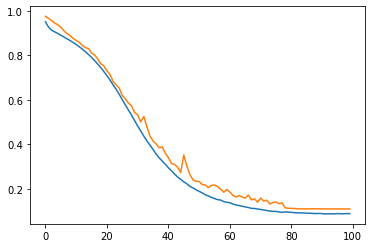

In [297]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [1]:
IMAGE_SIZE

NameError: name 'IMAGE_SIZE' is not defined

## Evaluation

## Results

In [27]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [28]:

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


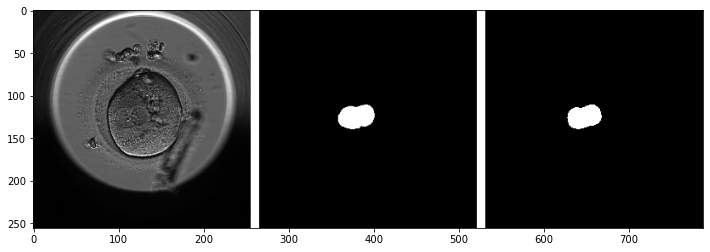

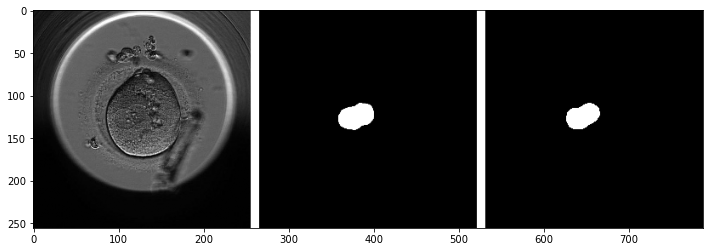

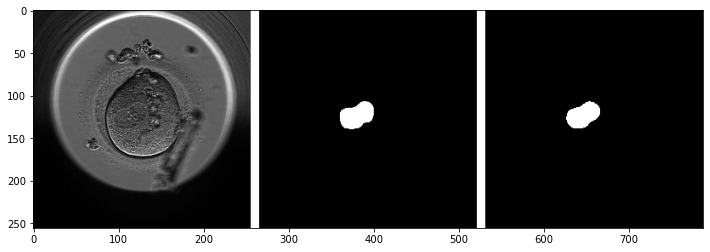

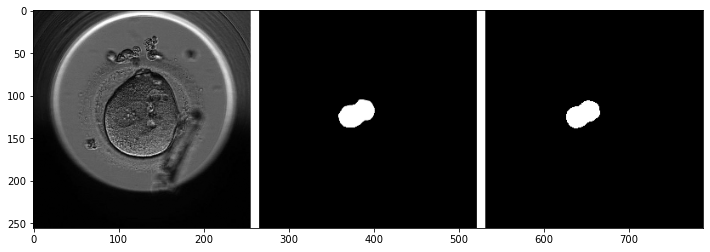

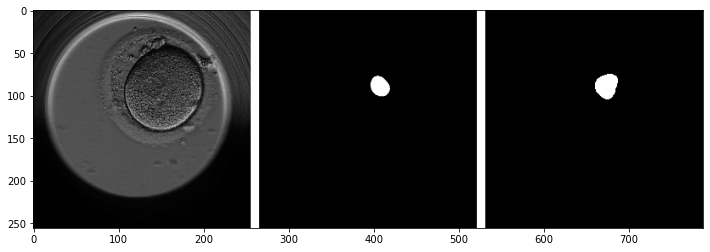

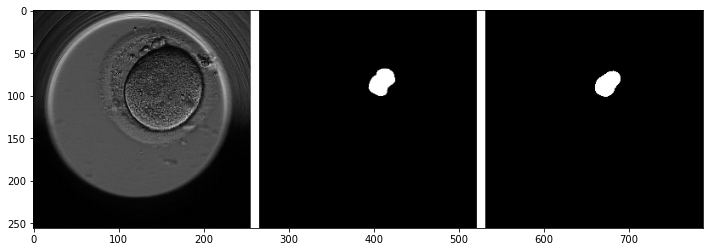

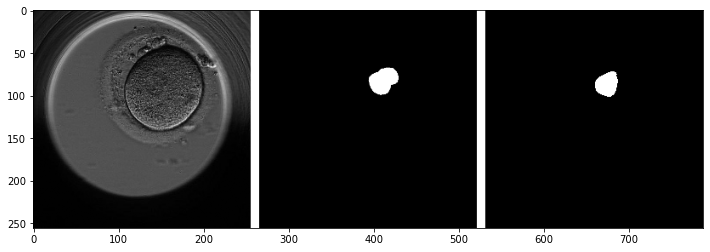

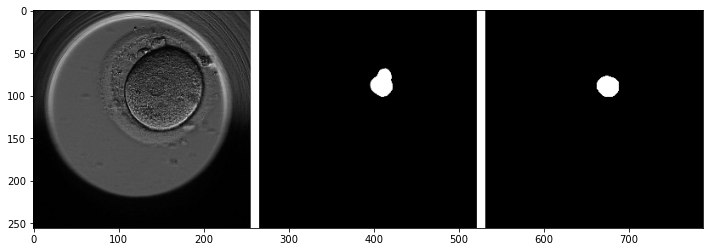

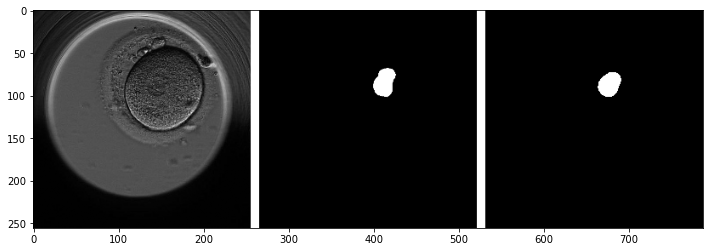

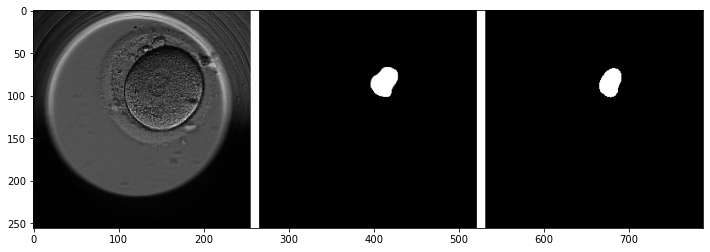

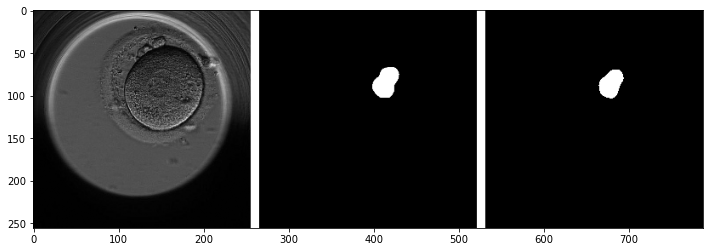

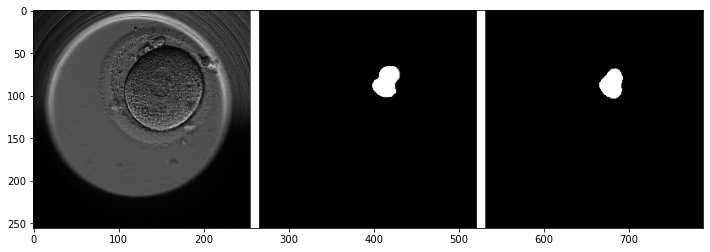

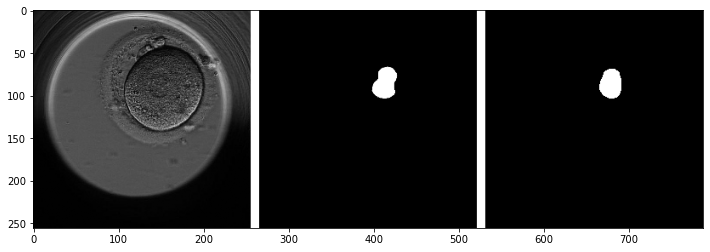

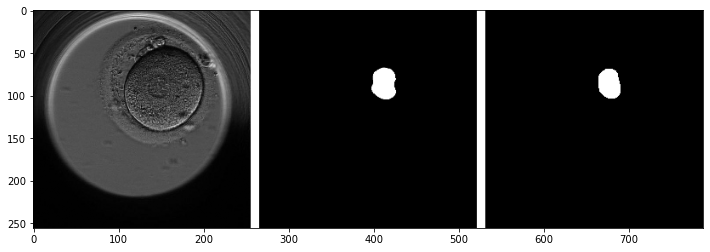

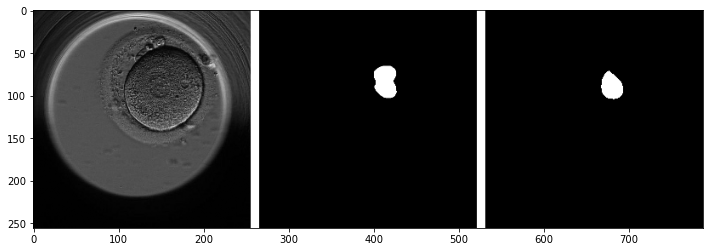

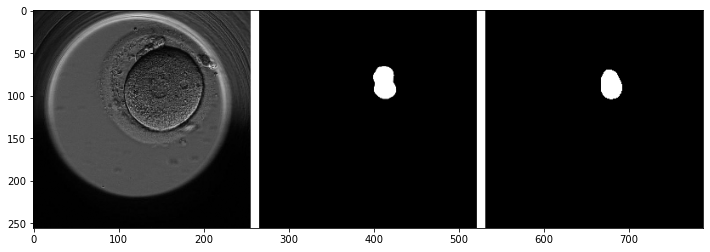

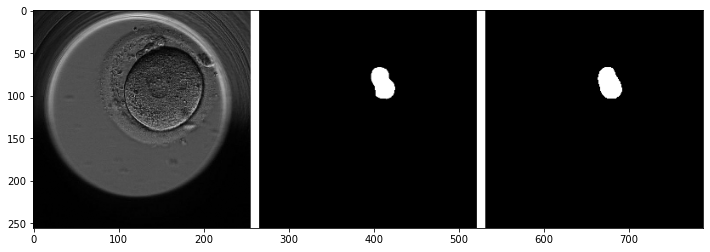

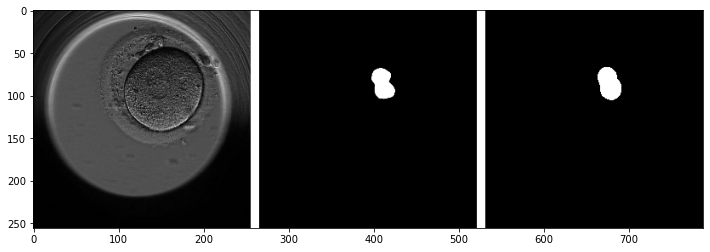

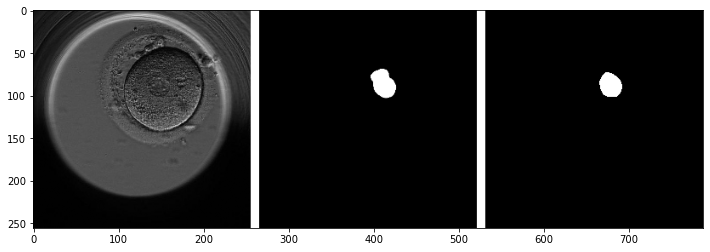

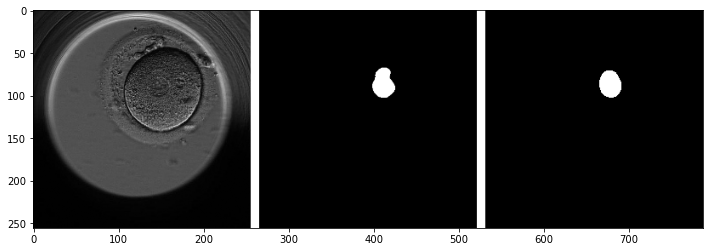

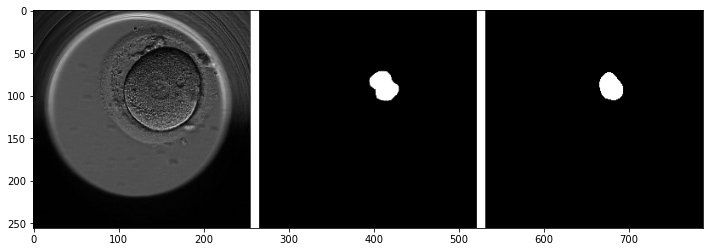

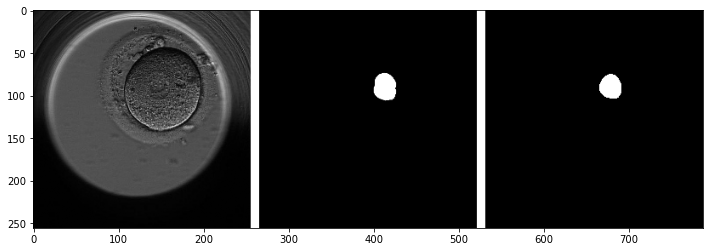

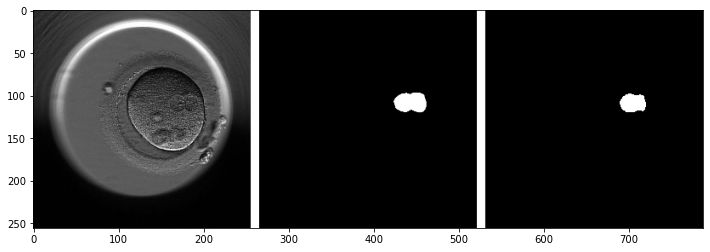

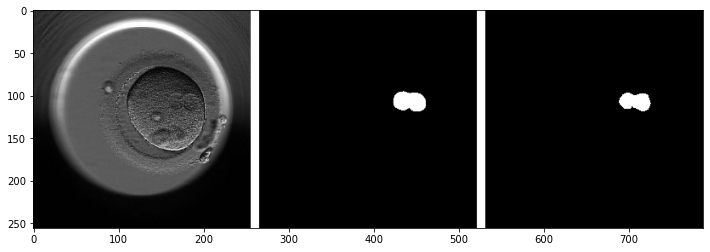

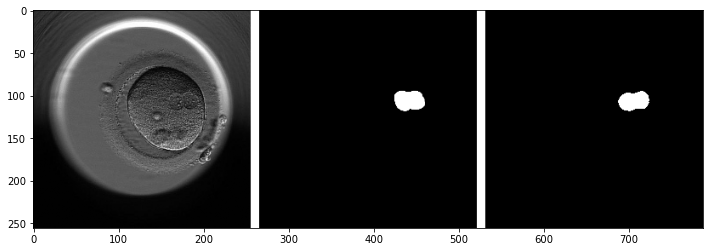

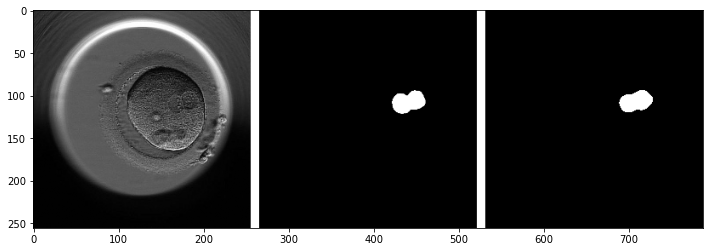

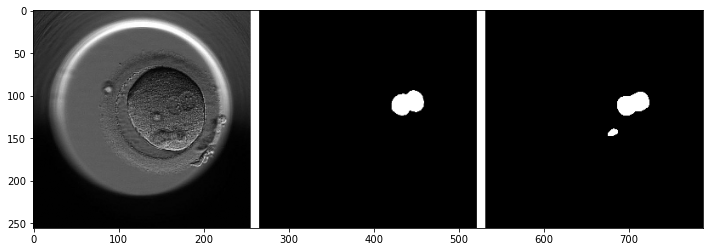

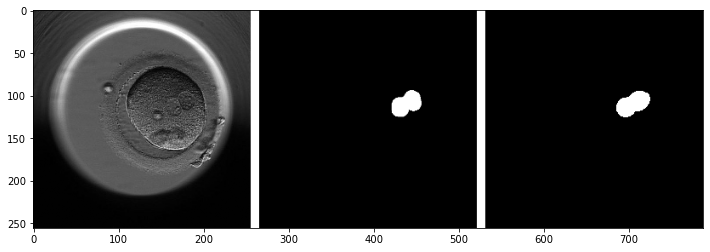

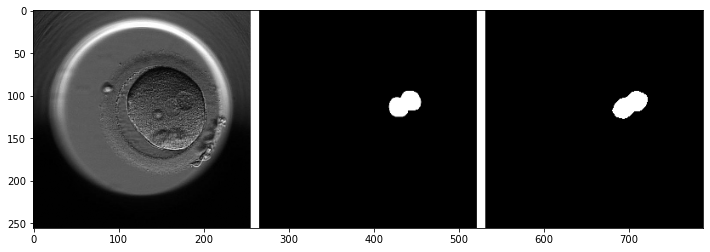

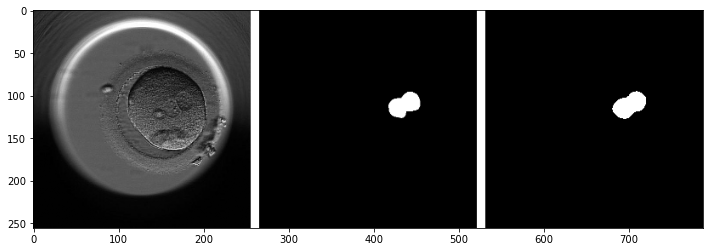

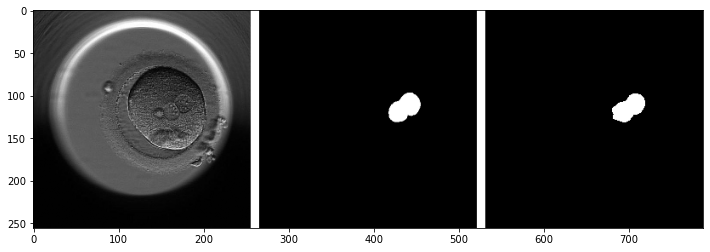

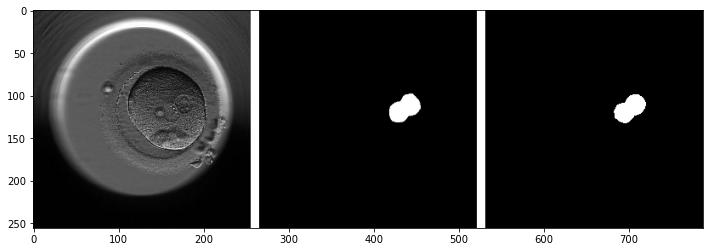

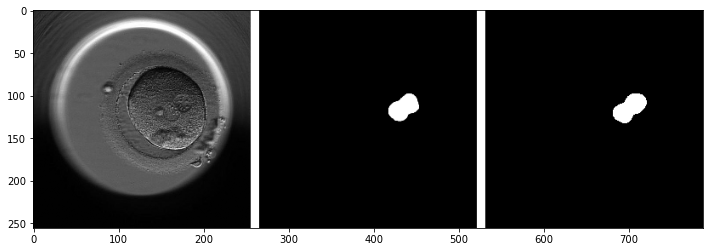

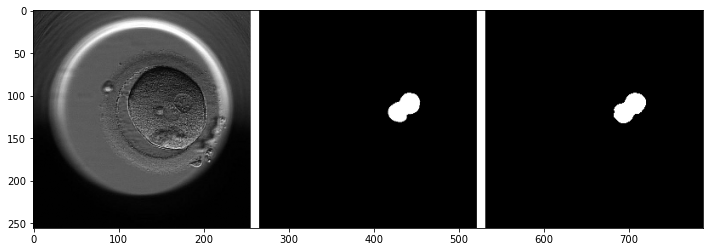

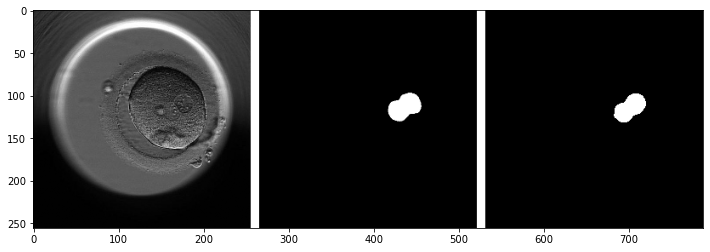

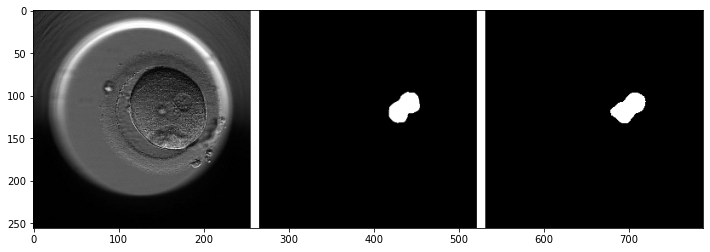

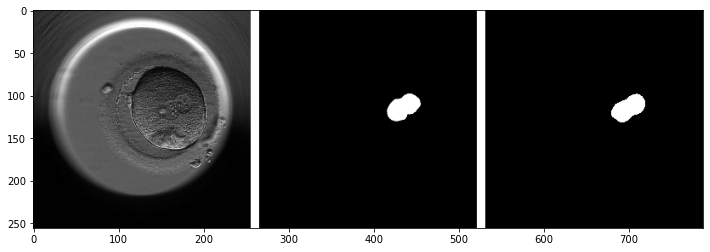

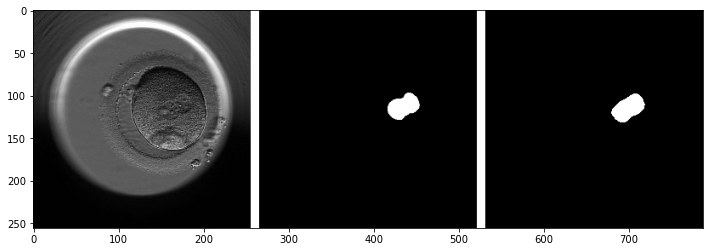

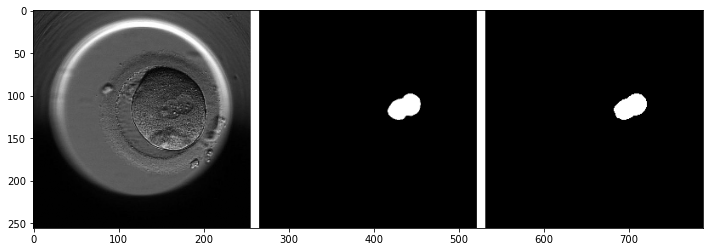

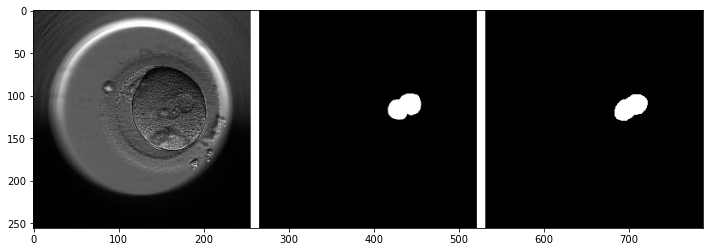

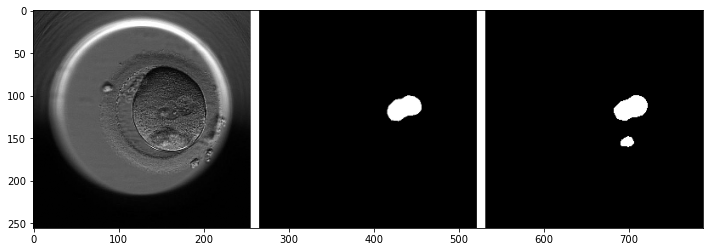

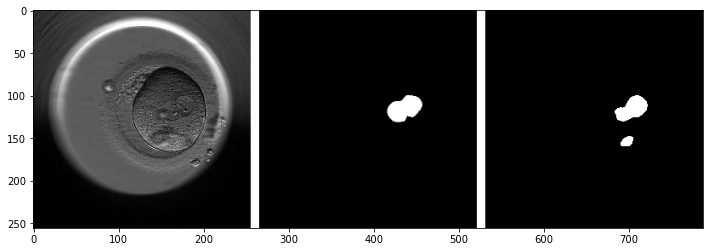

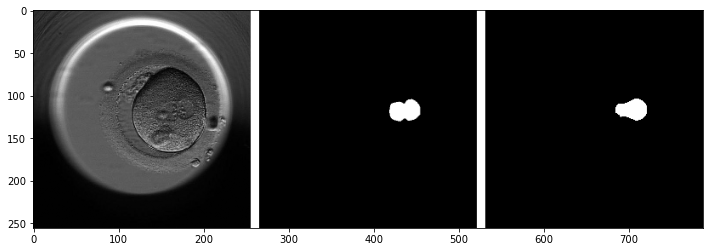

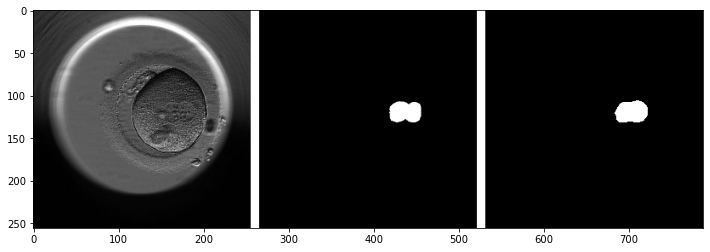

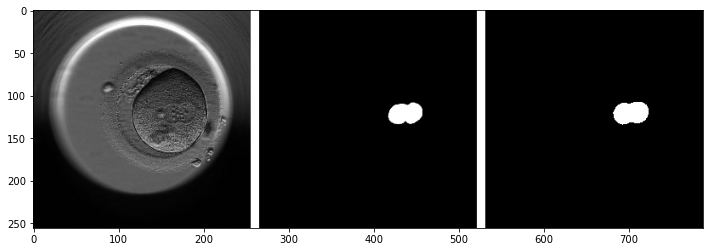

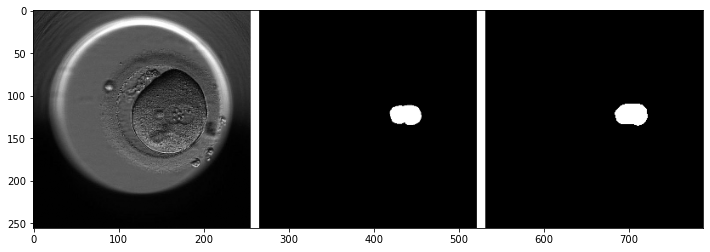

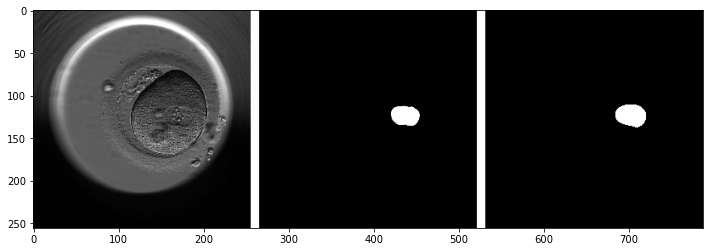

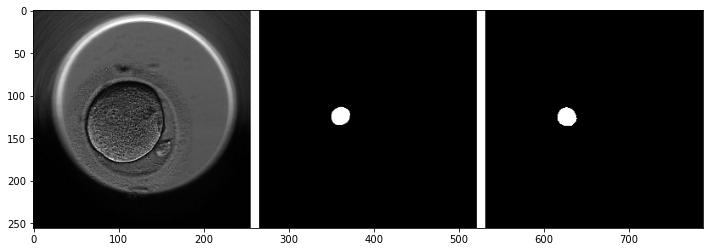

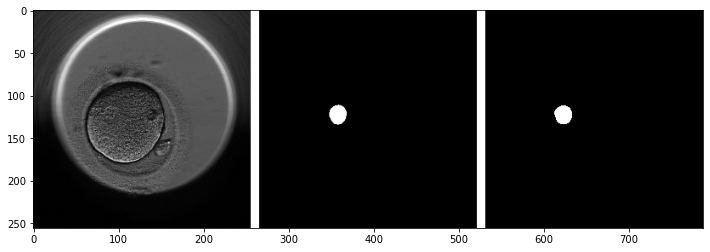

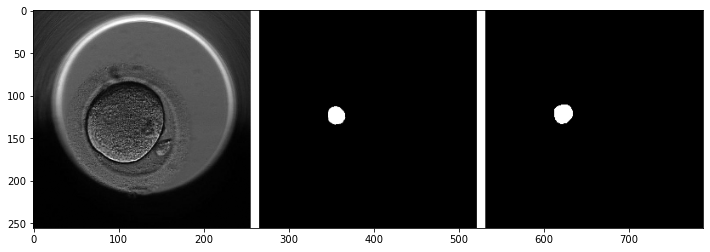

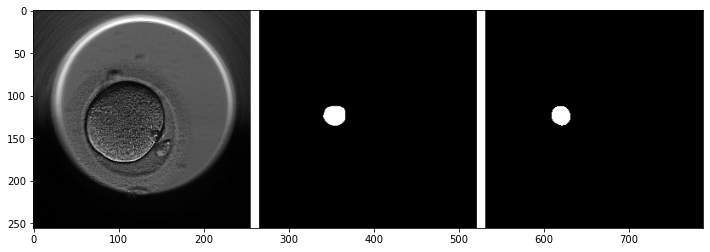

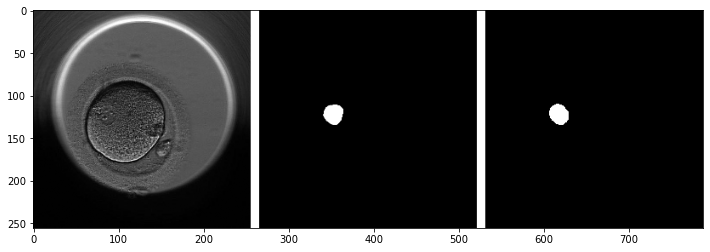

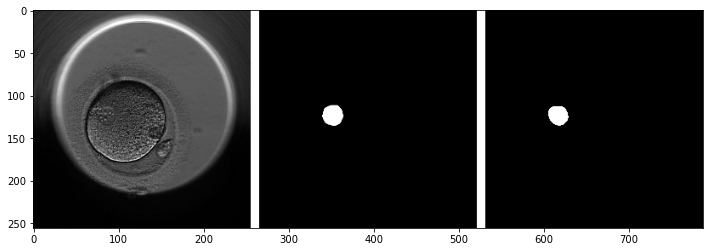

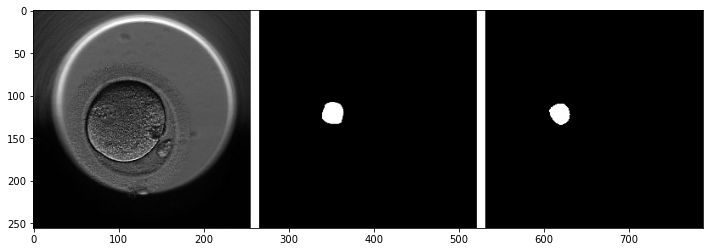

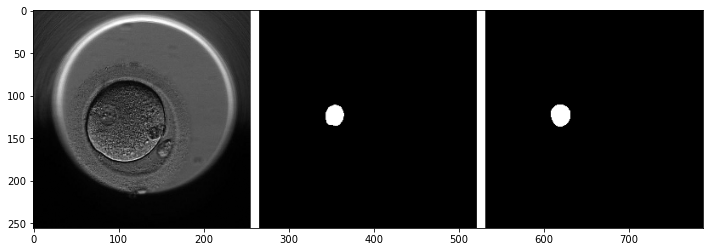

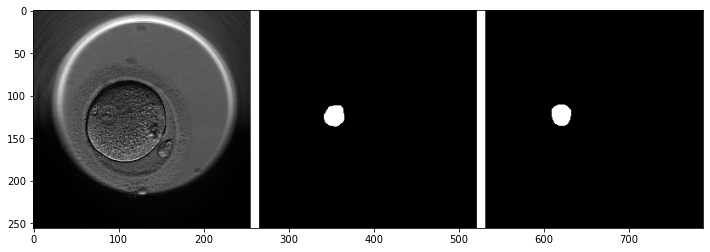

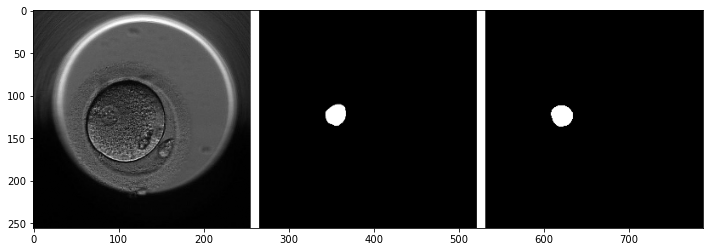

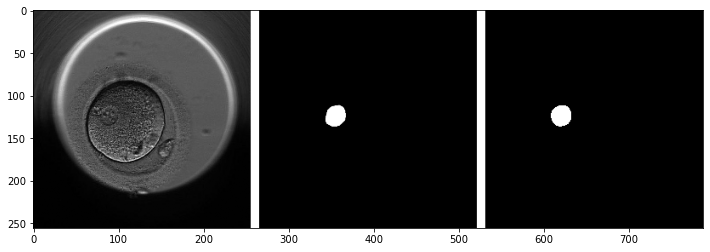

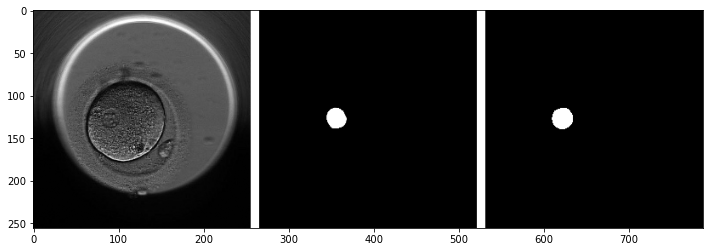

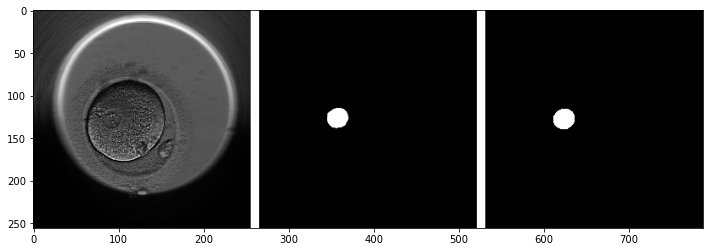

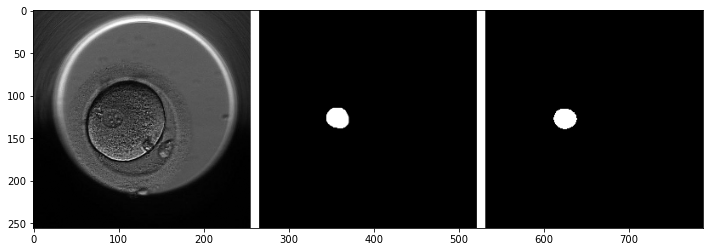

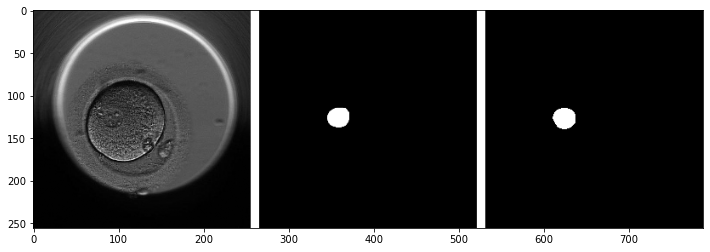

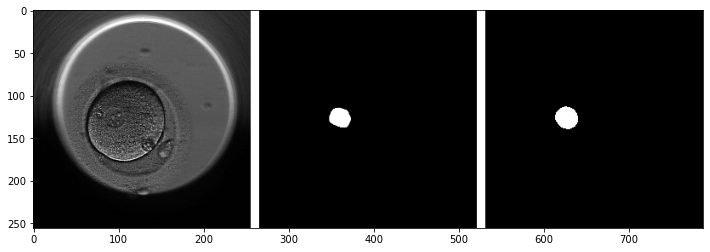

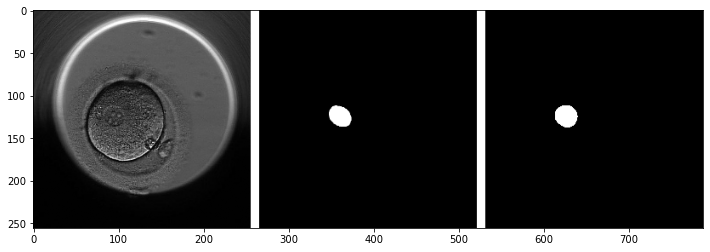

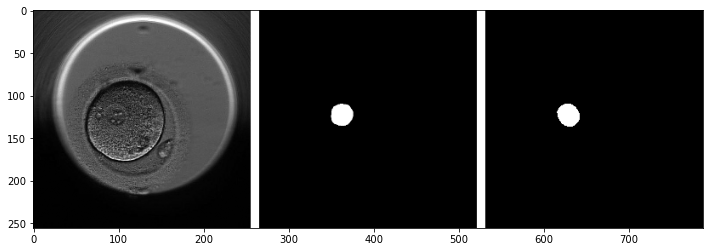

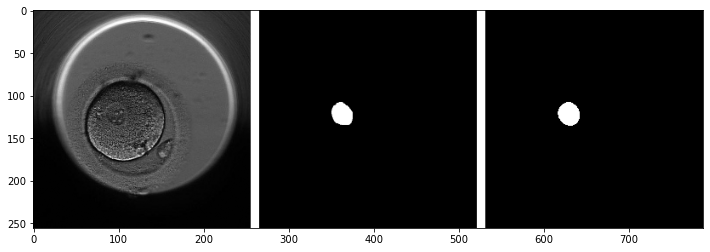

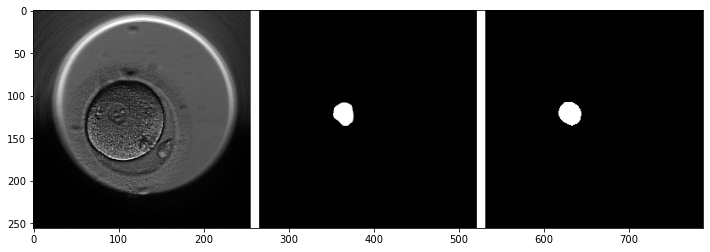

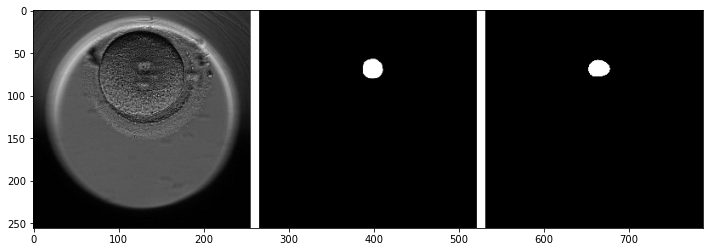

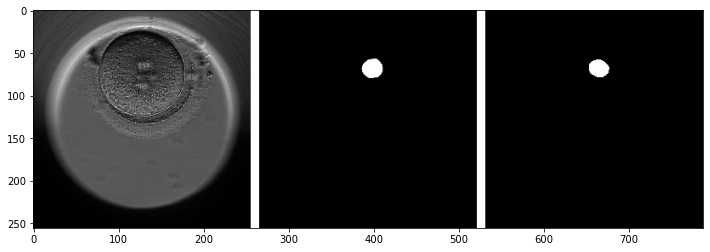

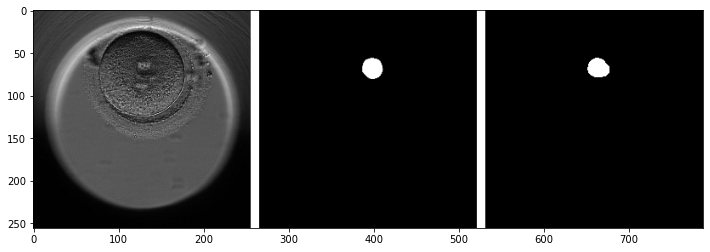

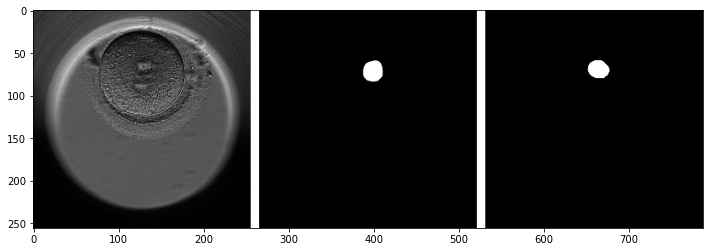

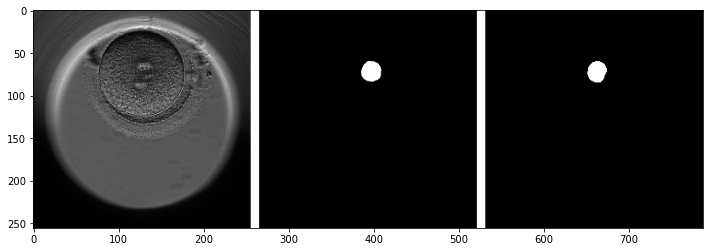

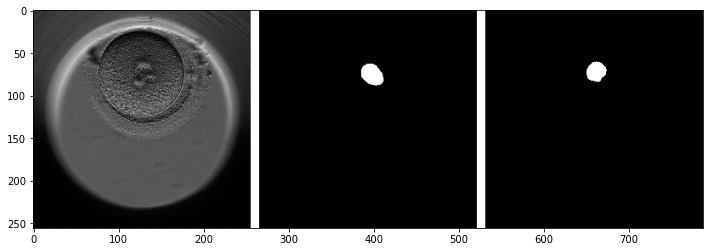

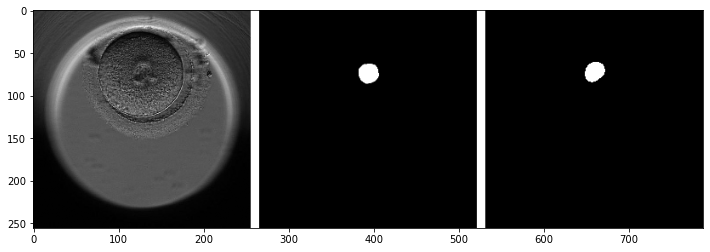

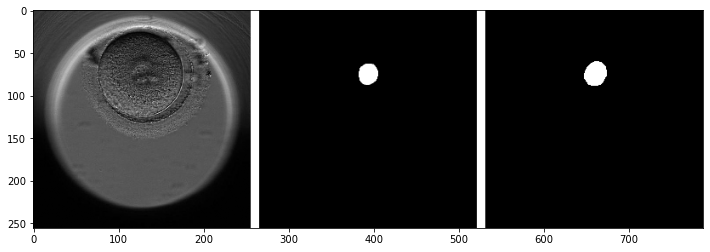

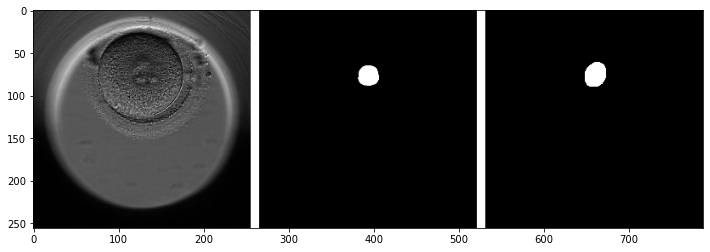

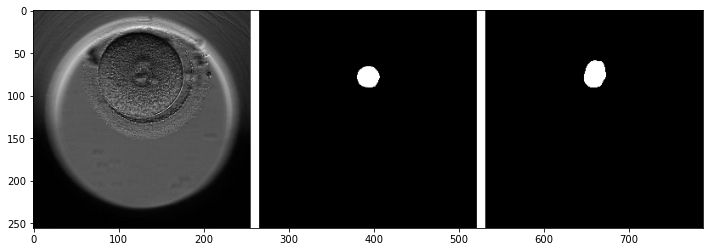

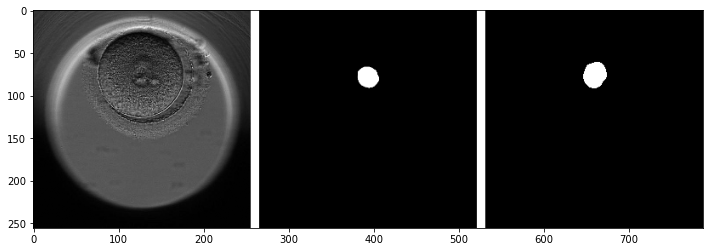

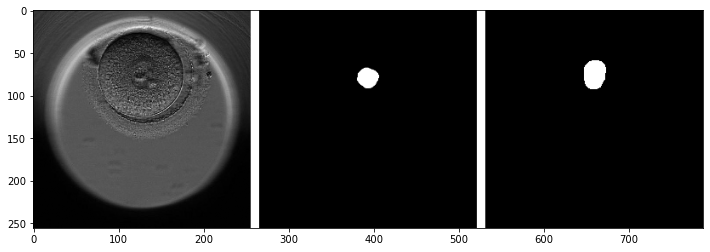

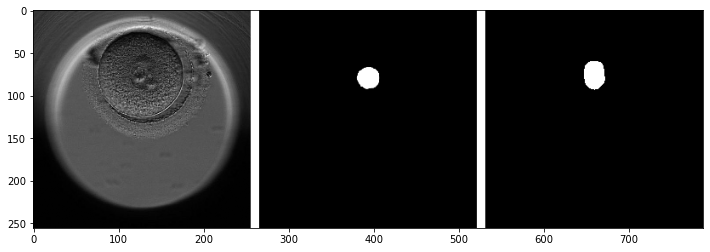

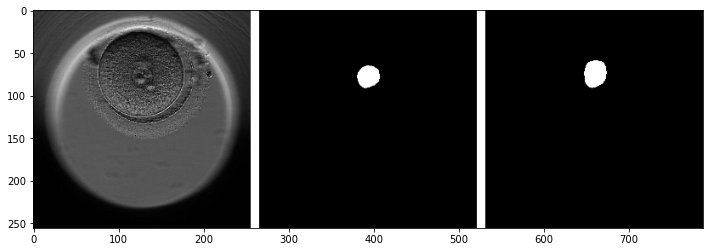

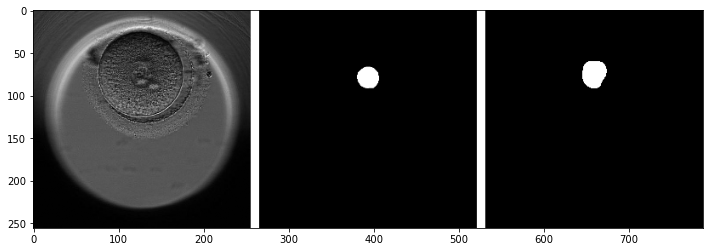

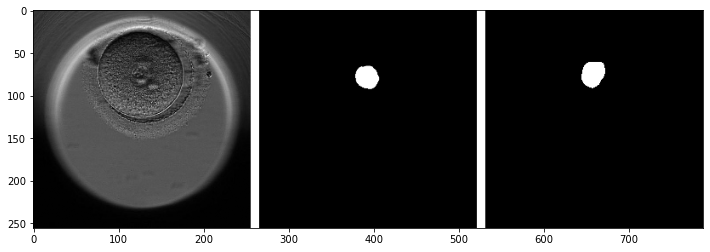

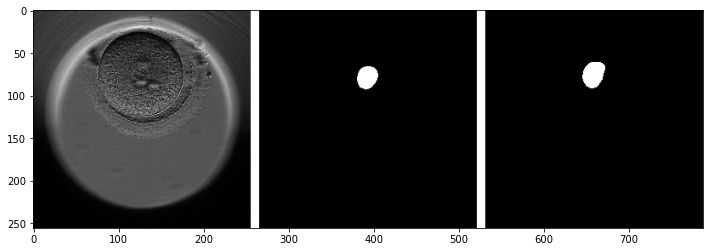

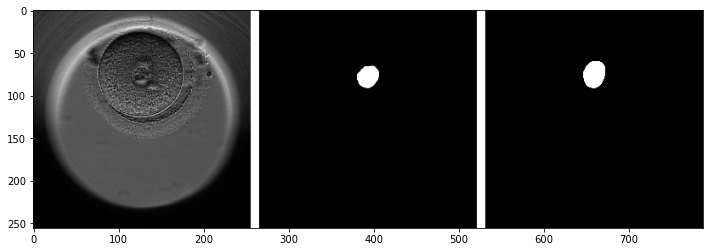

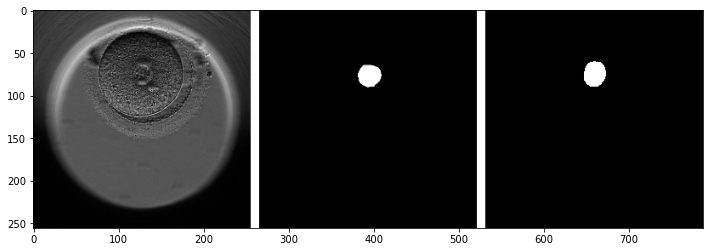

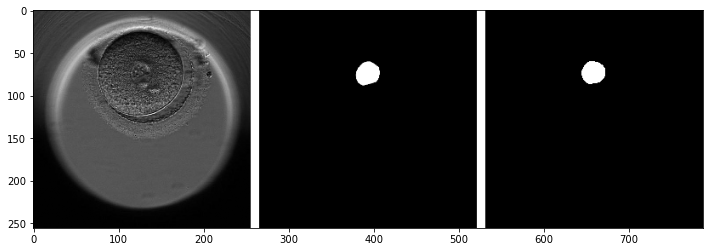

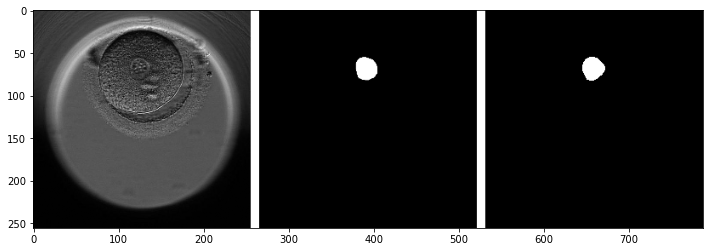

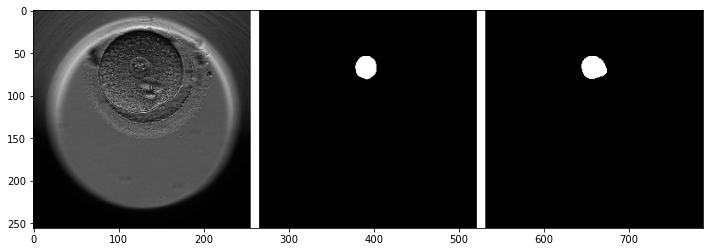

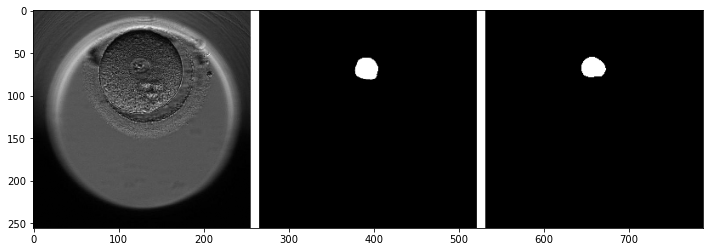

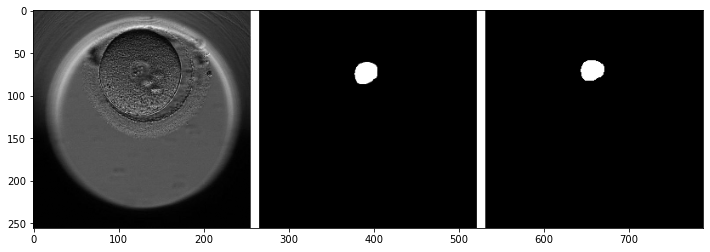

In [29]:
for i, (x, y) in enumerate(zip(valid_x, valid_y)):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

In [30]:
!mkdir -p saved_model
model.save('saved_model/basic_unet')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/basic_unet\assets


## How to Improve the Results

<ul>
    <li> Use data augmentation </li>
    <li> Use other pretrained encoder </li>
    <li> Use a different decoder or different blocks in the decoder. </li>   
 </ul>

# Thank You

FOLLOW US ON:
<ul>
<li><a href="https://www.youtube.com/idiotdeveloper"> YOUTUBE </a></li>
<li><a href="https://facebook.com/idiotdeveloper"> FACEBOOK </a></li>
<li><a href="https://twitter.com/nikhilroxtomar"> TWITTER </a></li>
<li><a href="https://www.instagram.com/nikhilroxtomar"> INSTAGRAM </a></li>
<li><a href="https://www.patreon.com/idiotdeveloper"> PATREON </a></li>
</ul>

In [31]:
from skimage.measure import regionprops
from skimage.draw import circle
def masks_to_green(x):
    green_masks = []
    centroids = []
    perimeters = []
    for i in x:
        temp = np.round(i[:,:,0])
        
        r = regionprops(temp.astype(int))
        try:
            centroids.append(r[0].centroid)
            perimeters.append(r[0].perimeter)
            x, y = circle(r[0].centroid[0],r[0].centroid[1], 3, shape=None)
        except:
            centroids.append(0)
            perimeters.append(0)
            #x, y = circle(r[0].centroid[0],r[0].centroid[1], 3, shape=None)
        #temp[x,y]=0
        temp = np.stack((temp,)*3, axis=-1)
        temp[:,:,0] = 0
        temp[:,:,2] = 0
        green_masks.append(temp)
    
    return np.array(green_masks), np.array(centroids), np.array(perimeters)


import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

font = cv2.FONT_HERSHEY_SIMPLEX
def put_text(img, count):
        #img = cv2.putText(img,f'{count}',(10,500), font, 10,(255,255,255),2)
        return cv2.putText(img,f'{count}',(10,200), font, 0.5,(255,255,255), 1)

In [32]:
test_files = glob(f'C:/Data/test_timelapse/*')

In [33]:
def save_videos(x, slide_id):
    height, width = 256, 256
    
    video = cv2.VideoWriter(f'/sample/videos/{slide_id}_pn.avi', 0, 4, (width,height))

    for image in x:
        video.write(image)

    cv2.destroyAllWindows()
    video.release()

In [34]:
import tqdm

In [35]:
dfs = []
import imageio
count = 0
for i in tqdm.tqdm(test_files):
    x = glob(f'{i}/*')
    slide_id = x[0].split('\\')[1][:-4]

    x.sort(key=natural_keys)

    test_images = np.array([read_image(i) for i in x[:200]])
    predicted = model.predict(test_images)

    green_masks, centroids, perimeters = masks_to_green(predicted)

    means = np.array([np.sum(i[:,:,0]*np.round(j[:,:,0]))/np.round(j[:,:,0]).sum() for i,j in zip(test_images, predicted)])
    area = np.array([np.sum(np.round(i[:,:,0])) for i in predicted])
    
    x = area
    mask = np.where(x<50)[0]
    i = np.argmax(np.diff(mask))
    #x[mask[i]:mask[i+1]]
    #area[:mask[i]] = 0
    #area[mask[i+1]:] = 0
    
    #means[:mask[i]] = 0
    #means[mask[i+1]:] = 0
    
    #perimeters[:mask[i]] = 0
    #perimeters[mask[i+1]:] = 0
    
    for j in range(mask[i]):
        pass
        #temp = np.zeros((256, 256, 1))
        #green_masks[j] = temp
    
    for j in range(mask[i+1], len(green_masks)):
        pass
        #temp = np.zeros((256, 256, 1))
        #green_masks[j] = temp
    
    temp_df = pd.DataFrame(columns = ['id', 'Area', 'Means', 'Perimeters'])
    temp_df['Area'] = area
    temp_df['Means'] = means
    temp_df['Perimeters'] = perimeters
    temp_df['id'] = count
    
    dfs.append(temp_df)
    
    
    p = np.array([i*0.8+0.2*np.round(j) for i,j in zip(test_images, green_masks)])
    with_text = [put_text(img,count) for count, img in enumerate(p)]
    with_text = [cv2.convertScaleAbs(i, alpha=(255.0)) for i in with_text]
    height, width = 256, 256
    
    video_path = f'C:/Users/hp/Desktop/annotation/sample/videos/{count}_pn.avi'
    video = cv2.VideoWriter(video_path, 0, 4, (width,height))

    for image in with_text:
        video.write(image)

    cv2.destroyAllWindows()
    video.release()
    count+=1
    #imageio.mimsave(f'sample/{slide_id}_pn.gif',with_text) 
    
    
    #rea_diff = np.
#per_dif = np.diff(perimeters)

  0%|                                           | 0/92 [00:00<?, ?it/s]C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  
C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
100%|██████████████████████████████████| 92/92 [07:28<00:00,  4.88s/it]


In [36]:
aggs = pd.concat(dfs)

0


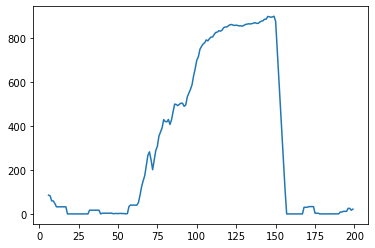

1


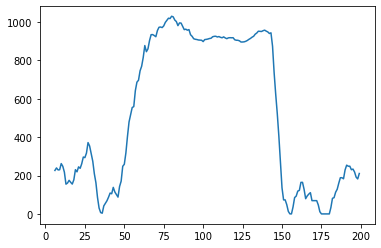

2


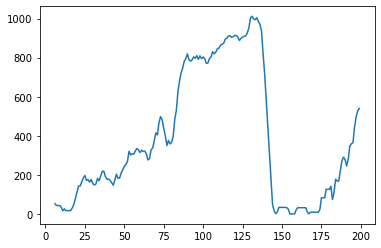

3


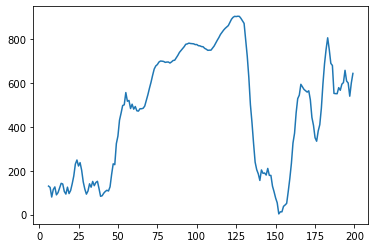

4


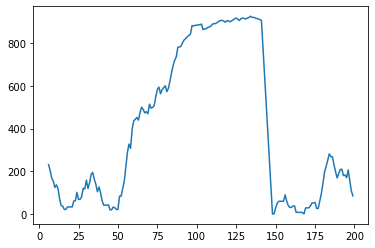

5


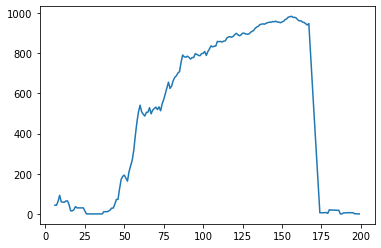

6


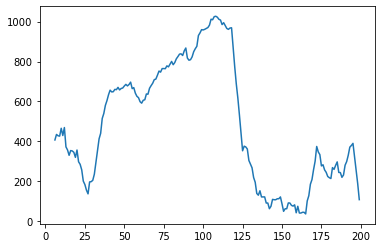

7


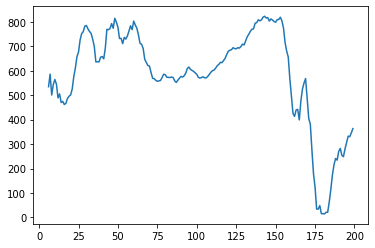

8


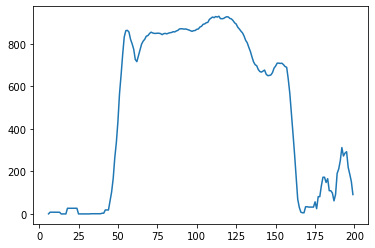

9


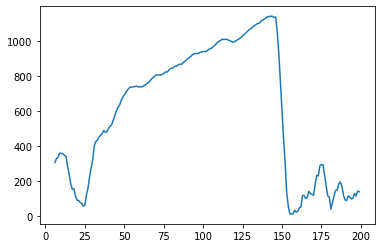

10


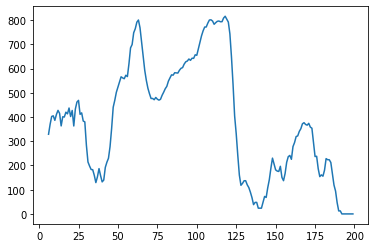

11


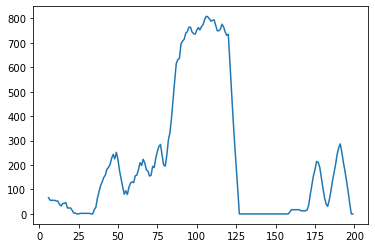

12


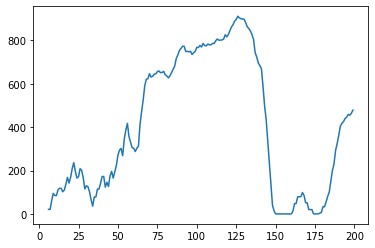

13


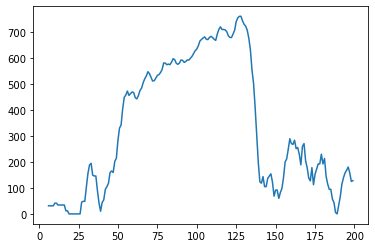

14


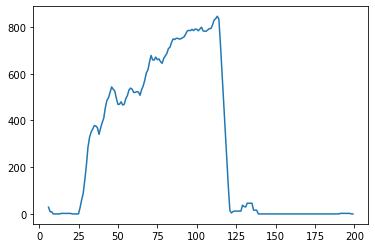

15


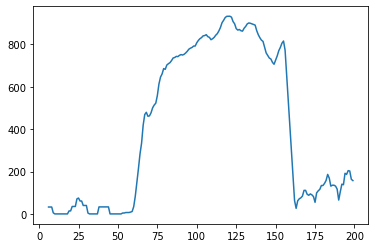

16


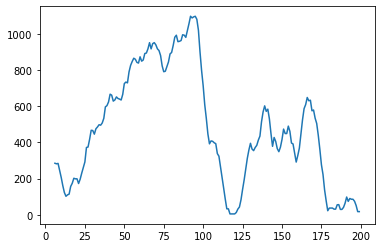

17


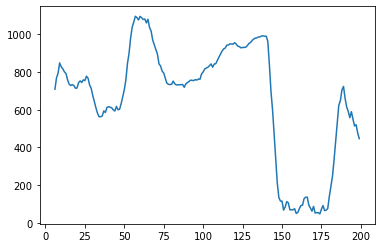

18


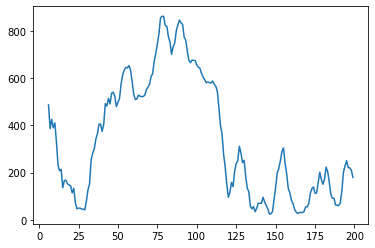

19


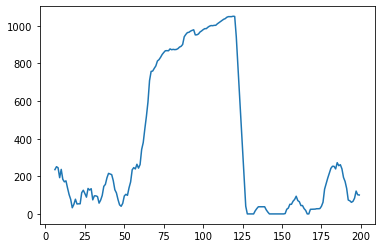

20


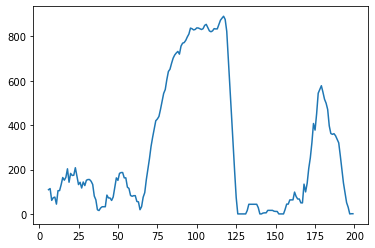

21


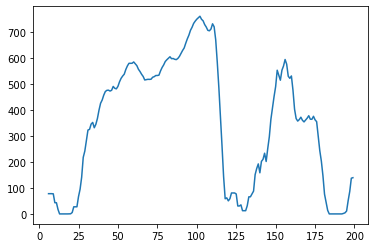

22


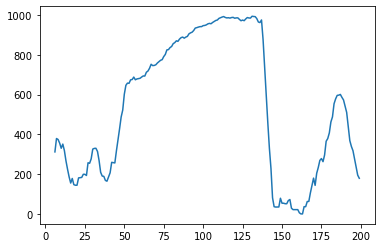

23


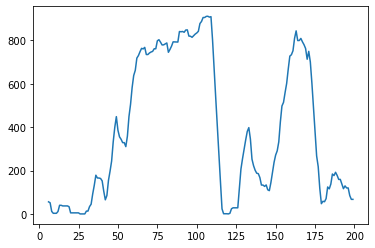

24


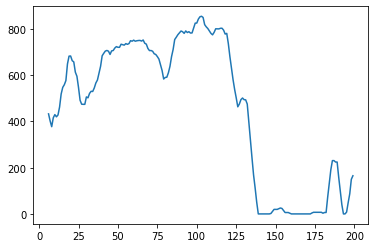

25


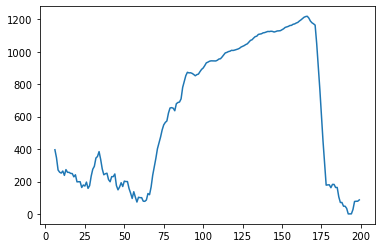

26


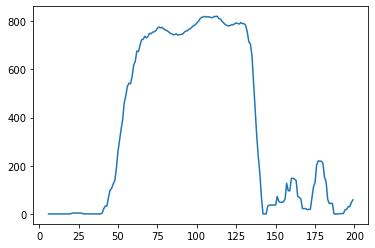

27


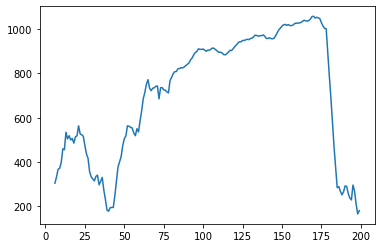

28


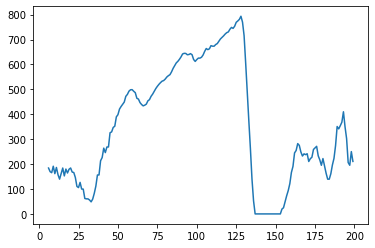

29


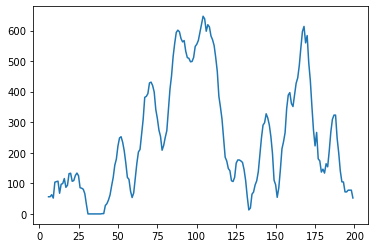

30


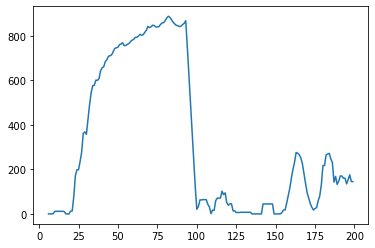

31


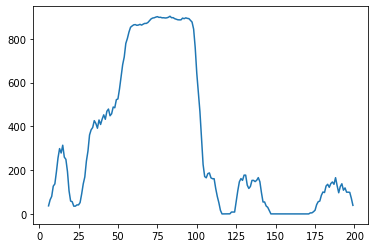

32


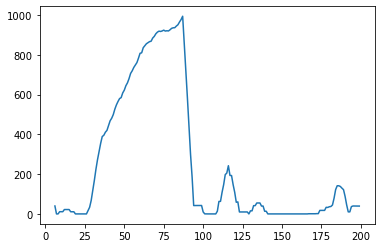

33


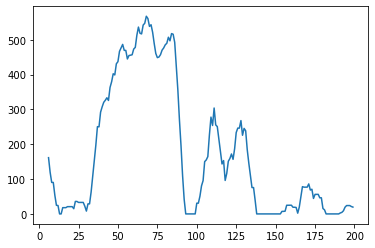

34


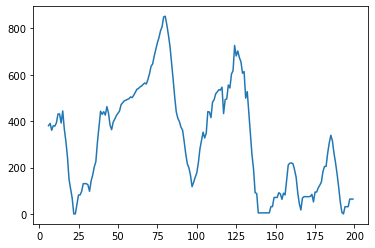

35


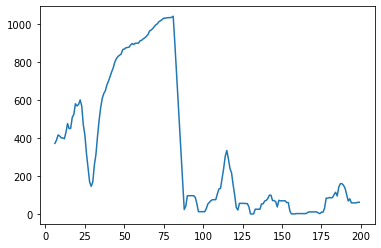

36


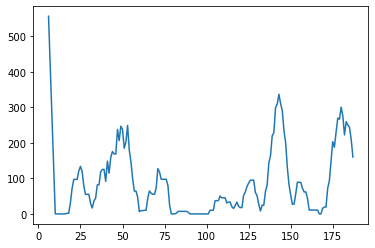

37


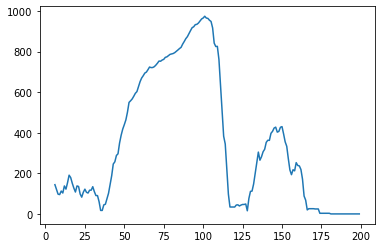

38


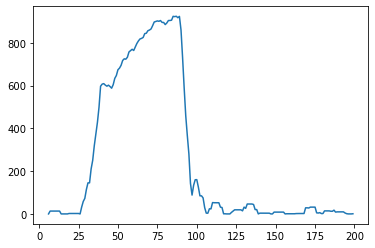

39


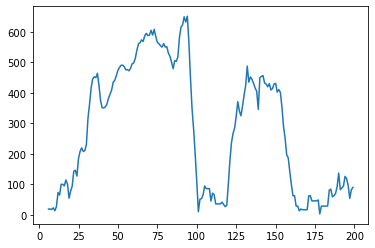

40


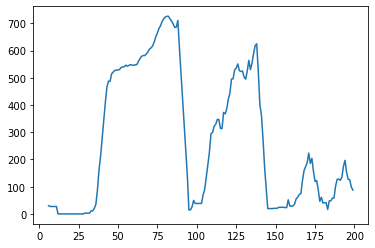

41


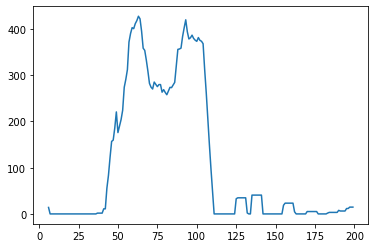

42


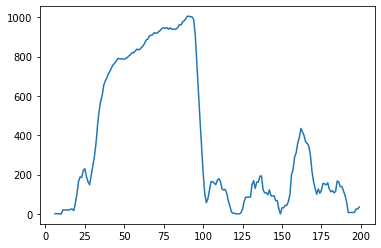

43


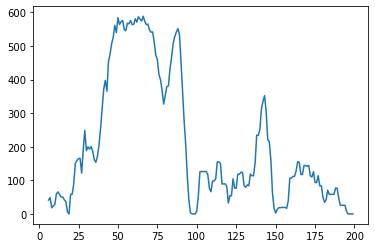

44


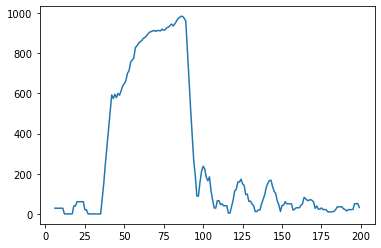

45


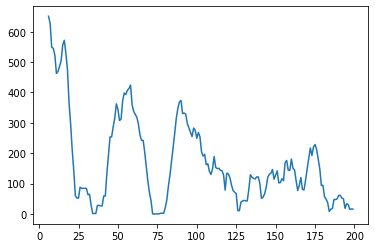

46


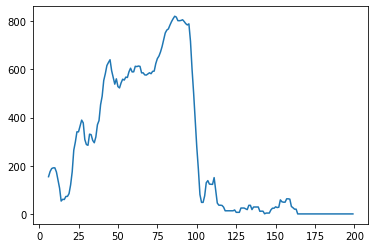

47


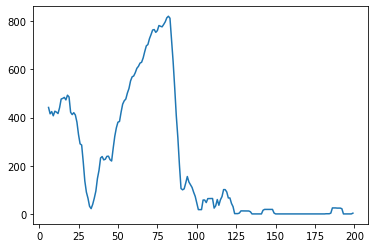

48


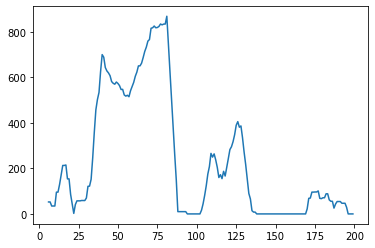

49


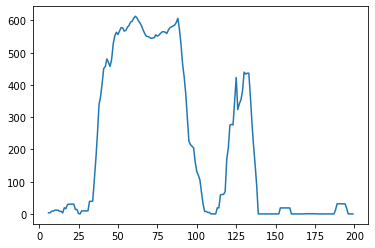

50


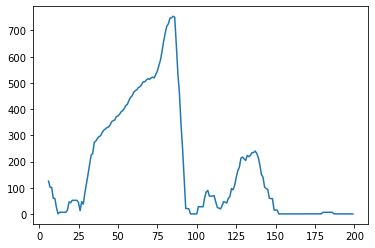

51


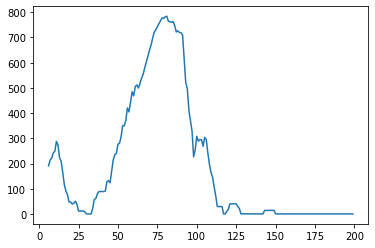

52


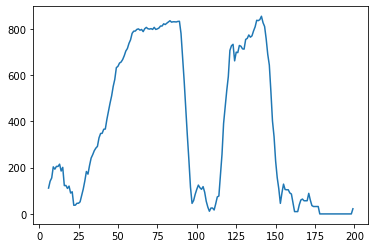

53


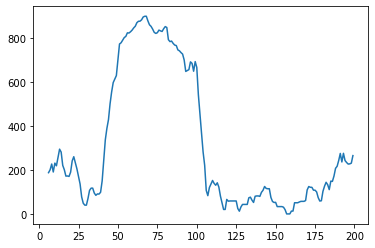

54


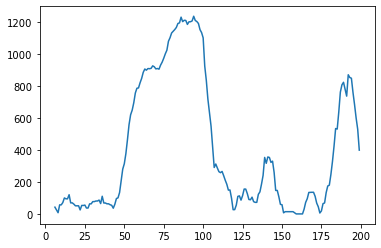

55


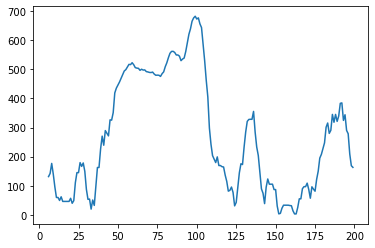

56


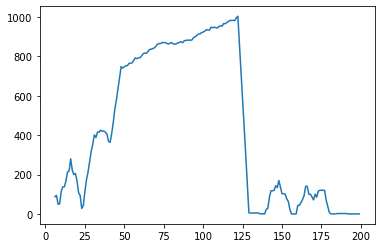

57


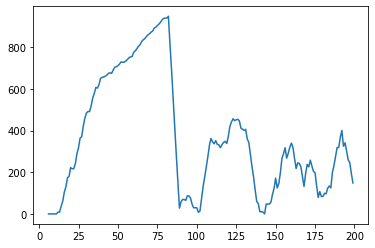

58


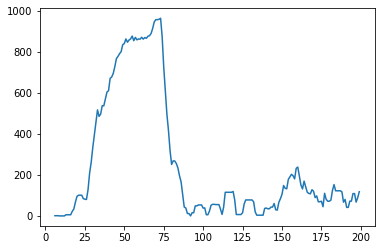

59


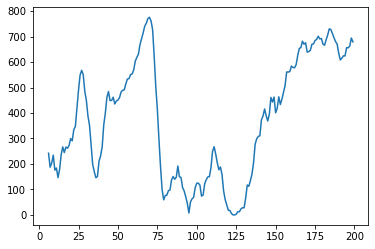

60


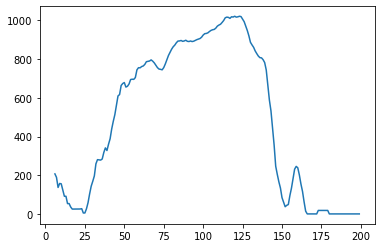

61


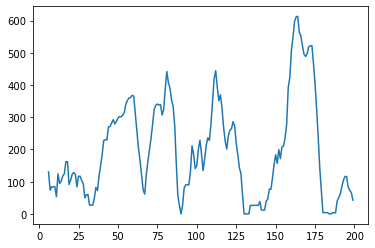

62


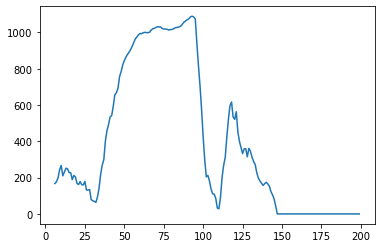

63


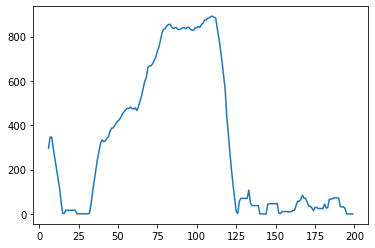

64


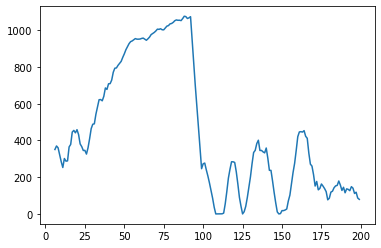

65


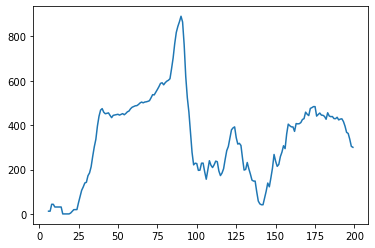

66


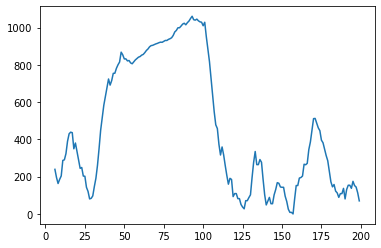

67


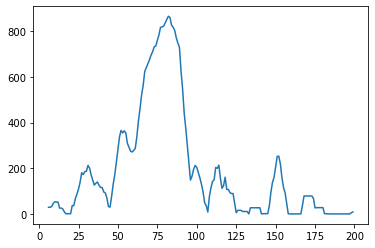

68


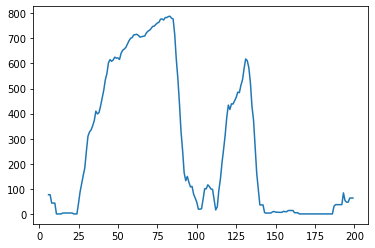

69


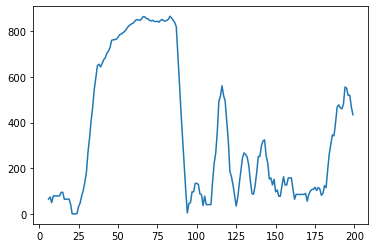

70


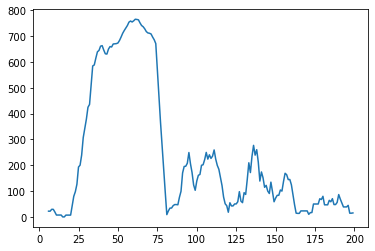

71


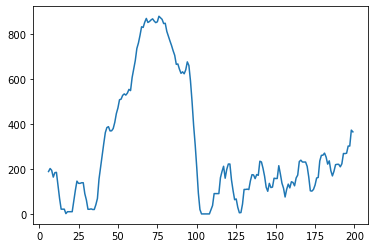

72


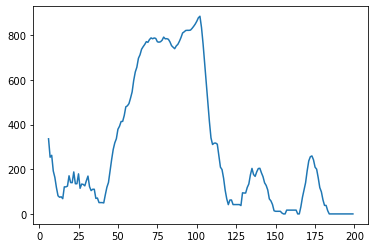

73


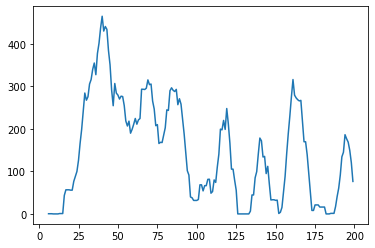

74


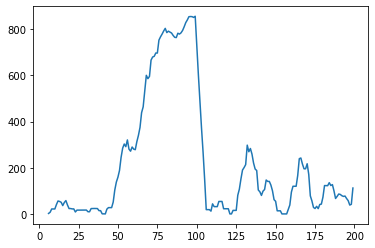

75


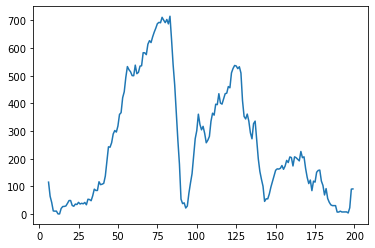

76


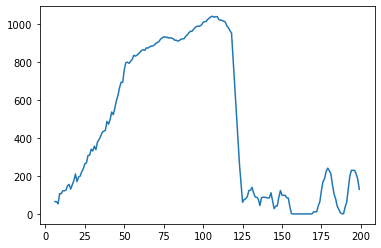

77


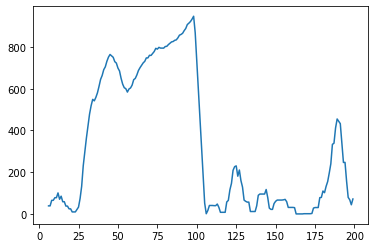

78


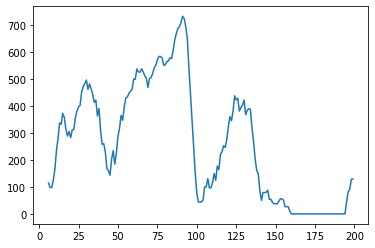

79


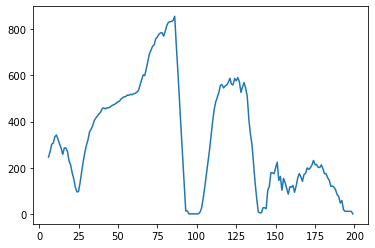

80


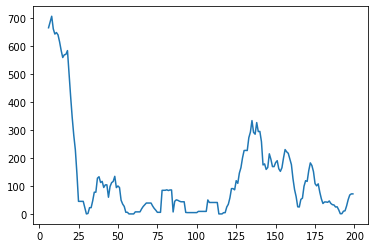

81


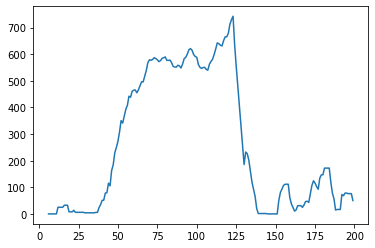

82


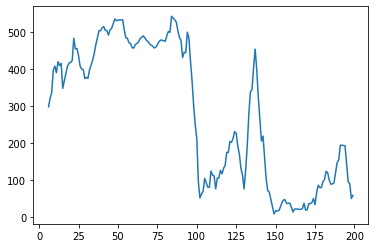

83


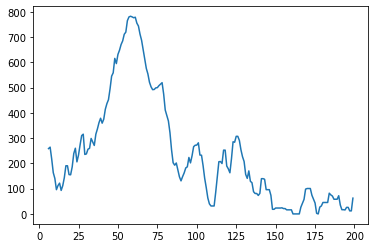

84


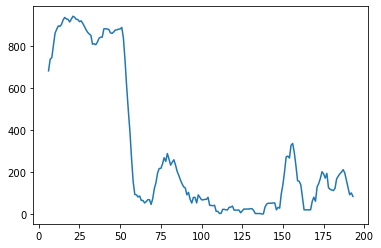

85


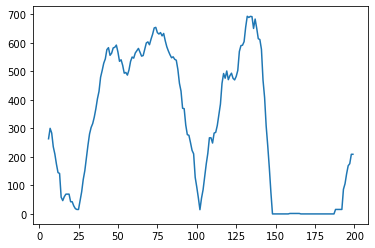

86


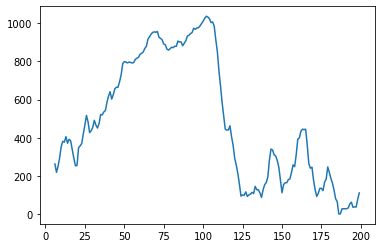

87


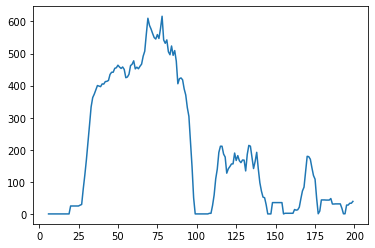

88


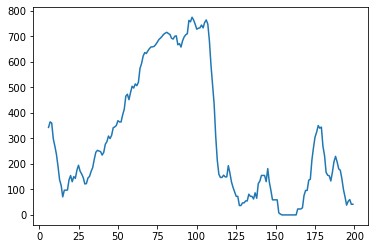

89


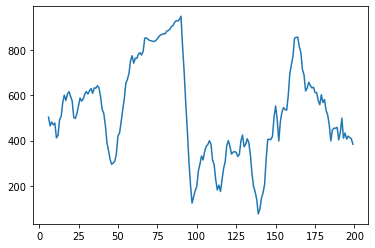

90


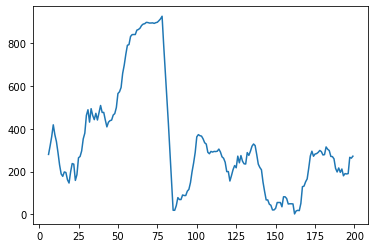

91


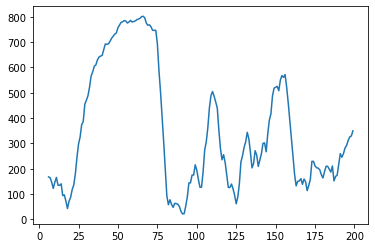

In [37]:
for a, val in aggs.groupby('id'):
    plt.plot(val.Area.rolling(7).mean())
    print(a)
    plt.show()

In [38]:
np.argmax(np.diff(mask))

6

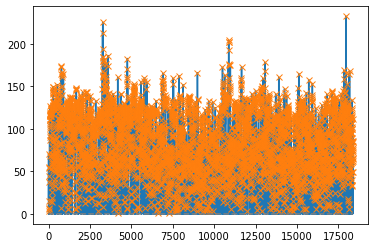

In [39]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
x = aggs.Perimeters.values
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()


In [40]:
mask

array([  3,   6,  12,  13,  15,  17,  18,  76,  79,  80,  81,  85,  87,
        88,  89,  90,  91,  92,  96,  98, 101, 103, 114, 115, 120, 121,
       125, 134, 139, 158, 159, 165, 167, 174, 176, 179, 183], dtype=int64)

In [41]:
area

array([137., 456., 240.,   0., 121., 213.,   7., 115., 327.,  72., 174.,
       250.,   0.,   0., 159.,   0.,  94.,   0.,  46., 203., 106., 374.,
       129., 398., 448., 420., 397., 449., 465., 607., 508., 572., 658.,
       707., 560., 622., 643., 646., 651., 684., 729., 719., 777., 632.,
       663., 720., 768., 787., 773., 811., 775., 741., 792., 785., 819.,
       760., 757., 803., 785., 747., 801., 833., 794., 776., 821., 832.,
       759., 758., 684., 737., 788., 763., 738., 756., 762., 316.,   0.,
       193.,  84.,  38.,   7.,  18.,  64., 137.,  66.,   0., 150.,   0.,
         0.,   0.,   0.,   0.,   8., 359., 253., 388.,   0., 216.,   0.,
       291., 214.,   0., 167.,   0., 635., 607., 516., 609., 546., 512.,
       110., 501., 452., 348.,   0.,  37., 198., 252., 282., 113.,   0.,
         0., 130.,  68.,  74.,  46., 295., 366., 611., 297., 301., 223.,
       314., 117.,   0., 171., 415., 658., 102.,   0., 298., 177., 452.,
       427., 412., 599., 375., 472., 675., 667., 45

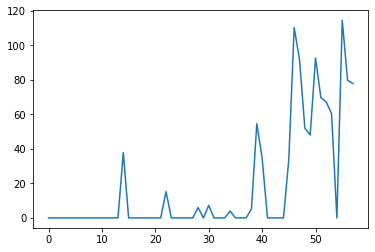

In [42]:
plt.plot(x[mask[i]:mask[i+1]])

In [43]:
aggs.to_csv('sample/feats.csv', index=False)

In [44]:
from importlib import reload
reload(plt)
#%matplotlib notebook

<module 'matplotlib.pyplot' from 'C:\\Users\\hp\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [45]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [46]:
%matplotlib notebook
%matplotlib inline

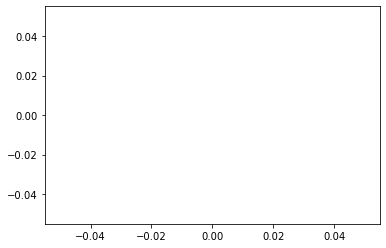

In [47]:
#%matplotlib notebook
#%matplotlib notebook
legends =[]
for g, val in aggs.groupby('id'):

    plt.plot(val[val['Area']>5000].Perimeters.values[:400])
    legends.append(g)

#plt.legend(legends)
plt.show()

In [48]:
extract = pd.read_excel('C:/Users/hp/Desktop/test/zoe.xlsx')

In [49]:
extract = extract[extract['Morphological Grade - Value'].notnull()].drop_duplicates('Slide ID')

In [50]:
in_excel = extract[extract['Morphological Grade - Value'].notnull()]['Slide ID'].unique()

In [51]:
in_excel

array(['D2011.06.01_S0060_I149', 'D2011.06.03_S0062_I149',
       'D2011.06.03_S0063_I149', ..., 'D2020.09.16_S02295_I0149_D',
       'D2020.09.16_S02296_I0149_D', 'D2020.09.18_S02297_I0149_D'],
      dtype=object)

In [52]:

filenames = glob('D:/sqllite3/*.pdb')  


In [53]:
filenames

['D:/sqllite3\\D2016.01.05_S1181_I149.pdb',
 'D:/sqllite3\\D2016.01.10_S1182_I149.pdb',
 'D:/sqllite3\\D2016.01.11_S1183_I149.pdb',
 'D:/sqllite3\\D2016.01.13_S1184_I149.pdb',
 'D:/sqllite3\\D2016.01.13_S1185_I149.pdb',
 'D:/sqllite3\\D2016.01.14_S1186_I149.pdb',
 'D:/sqllite3\\D2016.01.14_S1187_I149.pdb',
 'D:/sqllite3\\D2016.01.14_S1188_I149.pdb',
 'D:/sqllite3\\D2016.01.16_S1189_I149.pdb',
 'D:/sqllite3\\D2016.01.16_S1190_I149.pdb',
 'D:/sqllite3\\D2016.01.18_S1191_I149.pdb',
 'D:/sqllite3\\D2016.01.18_S1192_I149.pdb',
 'D:/sqllite3\\D2016.01.18_S1193_I149.pdb',
 'D:/sqllite3\\D2016.01.18_S1194_I149.pdb',
 'D:/sqllite3\\D2016.01.19_S1195_I149.pdb',
 'D:/sqllite3\\D2016.01.20_S1196_I149.pdb',
 'D:/sqllite3\\D2016.01.20_S1197_I149.pdb',
 'D:/sqllite3\\D2016.01.21_S1198_I149.pdb',
 'D:/sqllite3\\D2016.01.21_S1199_I149.pdb',
 'D:/sqllite3\\D2016.01.23_S1200_I149.pdb',
 'D:/sqllite3\\D2016.01.23_S1201_I149.pdb',
 'D:/sqllite3\\D2016.01.23_S1202_I149.pdb',
 'D:/sqllite3\\D2016.01.24_S1203

In [54]:
filenames = [f.split('\\')[1][:-4] for f in filenames]

In [55]:
common = pd.Series([f for f in filenames if f in in_excel], name='Slide ID')


In [56]:
final = pd.merge(common, extract)

In [57]:
sample = final.sample(100)

In [58]:
#sample = sample[sample['Morphological Grade - Value']!='1,5']

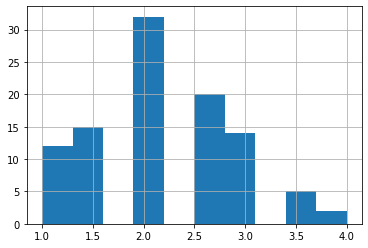

In [59]:
%matplotlib inline
sample['Morphological Grade - Value'].hist()

In [60]:
cols = ['Slide ID', 'Well', 'tPNf',
        't2', 't3', 't4', 't5',
        't6', 't8', 'Morphological Grade - Value']

In [61]:
#sample[cols].to_csv('sample.csv', index=False)

In [62]:
atemp = moving_average(np.diff(trying),7)
atemp2 = moving_average(trying,14)

NameError: name 'trying' is not defined

In [ ]:
plt.plot(np.diff(area))

In [ ]:
plt.plot()


In [ ]:


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization


In [ ]:
#Object detection
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import exposure


img = test_images[180][:,:,0]*np.round(predicted[180])[:,:,0]
#img = exposure.equalize_adapthist(img, clip_limit=0.01)*np.round(predicted[180])[:,:,0]
entr_img = entropy(img, disk(10),)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

#img0 = ax0.imshow(noise_mask, cmap='gray')
ax0.set_title("Object")
ax1.imshow(img, cmap='gray')
ax1.set_title("Noisy image")
ax2.imshow(entr_img, cmap='viridis')
ax2.set_title("Local entropy")

fig.tight_layout()

In [ ]:
img.shape

In [ ]:
plt.hist(np.round(predicted[400][:,:,0]).flatten())

In [ ]:
256**2-np.sum(np.round(predicted[400][:,:,0]))

In [ ]:
np.sum(np.round(predicted[400][:,:,0]))

In [ ]:
plt.hist(entr_img.flatten())

In [ ]:
plt.plot(trying)

In [ ]:
p = np.array([i*0.8+0.2*np.round(j) for i,j in zip(test_images, green_masks)])
font = cv2.FONT_HERSHEY_SIMPLEX
def put_text(img, count):
    #img = cv2.putText(img,f'{count}',(10,500), font, 10,(255,255,255),2)
    return cv2.putText(img,f'{count}',(10,200), font, 0.5,(255,255,255),1)

In [ ]:
with_text[0].shape

In [ ]:
plt.imshow(with_text[0])

In [ ]:
with_text = [cv2.convertScaleAbs(i, alpha=(255.0)) for i in with_text]

In [ ]:
'''count = 0
for im in p:
    cv2.imwrite(f'images_pn_masked/{count}.png', im)
    count+=1'''

In [ ]:
import imageio

imageio.mimsave('test.gif',with_text[150:300]) 

In [ ]:
from skimage import filters#
from skimage import feature

#meijering, sato, frangi, hessian, unsharp_mask
test = p[5][:,:,1]

#test = filters.gaussian(test, sigma=2)
#test = filters.unsharp_mask(test,radius=10)

s1 = filters.sobel(test)

s2 = filters.sobel_h(test)


s3 = filters.sobel_v(test)

canny = feature.canny(test)

In [ ]:
plt.hist(test.flatten())

In [ ]:
from skimage.segmentation import random_walker
markers = np.zeros(test.shape, dtype=np.uint)
markers[test > 0.7] = 1
markers[test < 0.3] = 2

# Run random walker algorithm
labels = random_walker(test, markers, beta=10, mode='bf')


In [ ]:
plt.imshow(test>0.2)
plt.show()
plt.imshow(s1)
plt.show()
plt.imshow(s2)
plt.show()
plt.imshow(s3)
plt.show()
plt.imshow(labels)

In [ ]:
color.gray2rgb(s2).shape

In [ ]:
radii

In [ ]:
sums = np.array([np.sum(np.round(i[:,:,0])) for i in predicted])

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
t = moving_average(sums[1:], n=7)
plt.plot(t)
plt.legend(['Area'])

In [ ]:
import imageio

imageio.mimsave('test.gif', p[150:250])

In [ ]:
for i, (x, y) in enumerate(zip(test_images[:10], predicted[:10])):
    #x = read_image(x)
    #y = read_mask(y)
    y_pred = y#model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    #image = np.concatenate(all_images, axis=1)
    #fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(x*mask_parse(y))
    plt.show()